## 1) Load in Imports

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.cm import ScalarMappable
from metpy.plots import SkewT, Hodograph
from metpy.units import units
import metpy.calc as mpcalc
from siphon.simplewebservice.wyoming import WyomingUpperAir
from datetime import datetime, timedelta
from matplotlib.gridspec import GridSpec
from ecape.calc import calc_ecape
from metpy.calc import wind_components, storm_relative_helicity

## 2) Retrieve Sounding Data from Wyoming Upper Air Site

In [43]:
# Current time and RAOB time determination
now = datetime.utcnow()

curr_year = now.year
curr_month = now.month
curr_day = now.day
curr_hour = now.hour

if curr_hour > 13:
    raob_hour = 12
    hr_delta = curr_hour - 12
elif curr_hour > 1:
    raob_hour = 0
    hr_delta = curr_hour - 0
else:
    raob_hour = 12
    hr_delta = curr_hour + 12

raob_time = now - timedelta(hours=hr_delta)
query_date = datetime(raob_time.year, raob_time.month, raob_time.day, raob_time.hour)

current = False

if not current:
    query_date = datetime(2020, 8, 2, 18)

station = 'OKX'

# Fetch the data using siphon
df = WyomingUpperAir.request_data(query_date, station)

### For reasons that are unclear to me, recent soundings from wyoming will reset height to 0 after reaching 10000m. 

### The old soundings don't have this problem, but new ones will. See the plot below.

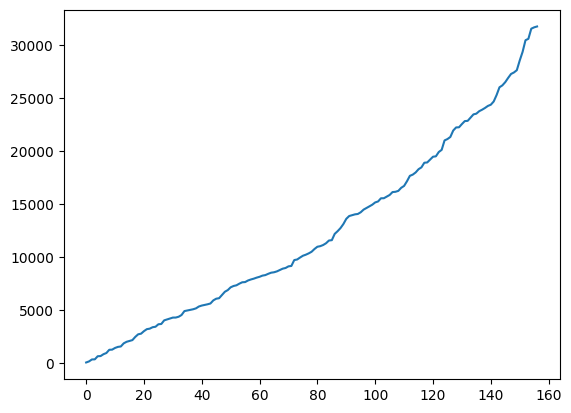

In [44]:
plt.plot(df['height'])

## The following cell resolves the issue. 

In [45]:
# Convert heights to a numpy array
heights = df['height'].values

# Detect and correct the height reset issue
for i in range(1, len(heights)):
    if heights[i] < heights[i-1] - 1000 and df['pressure'][i] < df['pressure'][i-1]:
        heights[i:] += 10000
        break

# Update the dataframe with the corrected heights
df['height'] = heights


### This is a check to see that the issue is gone

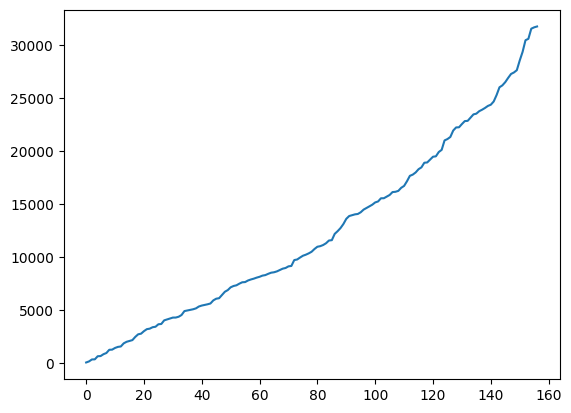

In [46]:
plt.plot(df['height'])

## 3) Run the behemoth. A lot happens here, it may take a little bit of time to run. 

#### If the upper level winds start to get messy on the hodograph, you can mask them by filtering the values on line 11 and 33 to whatever number you'd like.  

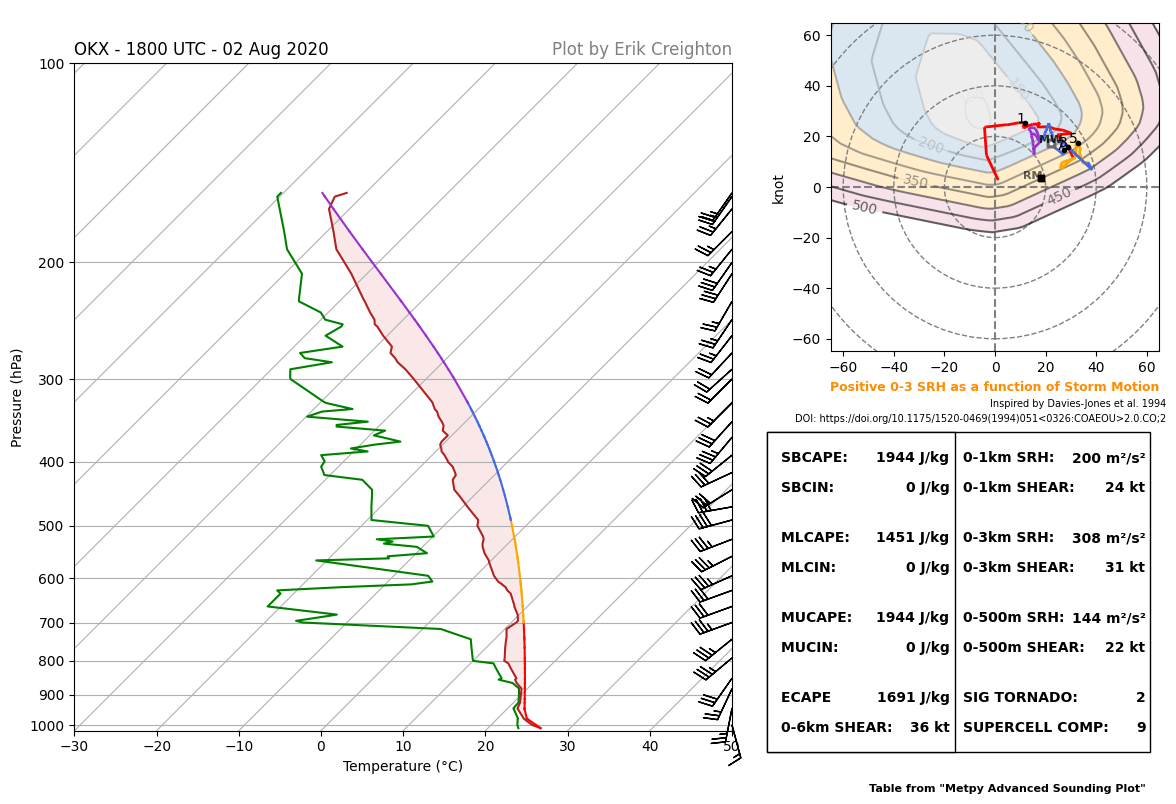

In [47]:
def plot_skewt_hodograph(df):
    # Extract variables and convert to appropriate units
    p = df['pressure'].values * units.hPa
    T = df['temperature'].values * units.degC
    Td = df['dewpoint'].values * units.degC
    u, v = mpcalc.wind_components(df['speed'].values * units.knots, df['direction'].values * units.degrees)
    height = df['height'].values * units.meter
    sq = mpcalc.specific_humidity_from_dewpoint(df['pressure'].values * units.hPa, df['dewpoint'].values * units.degC).to('g/kg')
    
    # Filter values up to 15000 meters
    mask = height.magnitude <= 14000
    p = p[mask]
    T = T[mask]
    Td = Td[mask]
    u = u[mask]
    v = v[mask]
    height = height[mask]
    sq = sq[mask]

    # Ensure there are no NaNs in the data
    valid = ~np.isnan(T) & ~np.isnan(Td) & ~np.isnan(u) & ~np.isnan(v) & ~np.isnan(height)
    p = p[valid]
    T = T[valid]
    Td = Td[valid]
    u = u[valid]
    v = v[valid]
    height = height[valid]
    sq = sq[valid]
    
    # Define custom colormap for parcel
    colors = ['r', 'orange', 'royalblue', 'darkorchid']
    cmap = ListedColormap(colors)
    boundaries = [0, 3000, 6000, 9000, 14000]
    norm = BoundaryNorm(boundaries, cmap.N)
   
    # Define custom colormap for SRH
    colors1 = ['darkgray', 'steelblue', 'orange', 'palevioletred']
    cmap1 = ListedColormap(colors1)
    boundaries1 = [0, 150, 250, 400, 1000]
    norm1 = BoundaryNorm(boundaries, cmap1.N)

    # Create the figure and set up the layout
    fig = plt.figure(figsize=(14, 10))
    gs = GridSpec(2, 2, width_ratios=[2, 1])  # Two subplots: one for Skew-T and one for Hodograph

    # Skew-T plot
    skew = SkewT(fig, rotation=45, subplot=gs[:, :-1])
    skew.plot(p, T, 'firebrick')
    skew.plot(p, Td, 'g')
    skew.ax.set_ylim(1020, 100)
    skew.ax.set_xlim(-30, 50)
    interval = np.logspace(2, 3, 40) * units.hPa
    idx = mpcalc.resample_nn_1d(p, interval)
    skew.plot_barbs(pressure=p[idx], u=u[idx], v=v[idx])

    # Parcel profile
    parcel_prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
    for i in range(len(p) - 1):
        skew.ax.plot(parcel_prof[i:i+2], p[i:i+2], color=cmap(norm(height.magnitude[i])))

    skew.shade_cape(p, T, parcel_prof, alpha=0.1, label='SBCAPE')
    skew.shade_cin(p, T, parcel_prof, Td, alpha=0.1, label='SBCIN')
    skew.ax.set_xlabel('Temperature (°C)')
    skew.ax.set_ylabel('Pressure (hPa)')
    skew.ax.set_title(f"{station} - {query_date.strftime('%H00 UTC - %d %b %Y')}", loc='left')
    skew.ax.set_title("Plot by Erik Creighton", loc='right', color='grey')

    # Hodograph plot
    hodo_ax = fig.add_subplot(gs[0, 1])
    h = Hodograph(hodo_ax, component_range=65)
    h.add_grid(increment=20)
    h.plot_colormapped(u, v, height, linewidth=2, cmap=cmap, norm=norm, zorder=5)
    RM, LM, MW = mpcalc.bunkers_storm_motion(p, u, v, height)
    
    # Add height markers at 1000m increments
    for ht in range(1000, 8001, 2000):
        index = np.argmin(np.abs(height.magnitude - ht))
        if np.isfinite(u[index]) and np.isfinite(v[index]):
            hodo_ax.plot(u[index], v[index], 'o', markersize=3, color='black', zorder=9)
            hodo_ax.text(u[index], v[index], f'{ht//1000}', fontsize=10, ha='right', zorder=9)
            h.ax.text((RM[0].m + 0.5), (RM[1].m - 0.5), 'RM', weight='bold', ha='right', fontsize=8, alpha=0.2, zorder=10)
            h.ax.plot(0, 0, RM[0].m - 0.3, RM[1].m - 0.3, 's', markersize=4, color='black', alpha=0.6, zorder=10)
            h.ax.plot((MW[0].m + 0.5), (MW[1].m - 0.5), 's', markersize=5.5, color='dimgray', alpha=0.6, zorder=9)
            h.ax.plot((MW[0].m + 0.5), (MW[1].m - 0.5), 's', markersize=2, color='white', alpha=0.6, zorder=10)
            h.ax.text((MW[0].m + 0.5), (MW[1].m - 0.5), 'MW', weight='bold', ha='center', color='black', fontsize=8, alpha=0.3, zorder=10)
            h.ax.set_xlabel('Positive 0-3 SRH as a function of Storm Motion', color='darkorange', weight='bold', fontsize=9)
    u_wind, v_wind = u, v
    # Create a grid for SRH contours
    u_grid, v_grid = np.meshgrid(np.linspace(-100, 100, 100), np.linspace(-100, 100, 100))
    
    # Compute SRH for each grid point
    srh_grid_0_3km = np.zeros_like(u_grid)
    
    for i in range(u_grid.shape[0]):
        for j in range(u_grid.shape[1]):
            u_test = u_grid[i, j] * units.knots
            v_test = v_grid[i, j] * units.knots
            srh_value = storm_relative_helicity(height, u_wind, v_wind, depth=3000 * units.meter, storm_u=u_test, storm_v=v_test)[0]
            srh_grid_0_3km[i, j] = srh_value.magnitude
    
    # Plot SRH contours with separate colormaps for positive values
    levels_positive = np.arange(50, 501, 50)
    
    contour_positive1 = plt.contourf(u_grid, v_grid, srh_grid_0_3km, levels=levels_positive, cmap=cmap1, alpha=0.2, zorder=1)
    contour_positive = plt.contour(u_grid, v_grid, srh_grid_0_3km, levels=levels_positive, cmap='gray_r', alpha=0.6, zorder=2)
    
    plt.clabel(contour_positive, inline=True, fontsize=10, fmt='%1.0f')
        # Calculate additional severe weather parameters
    kindex = mpcalc.k_index(p, T, Td)
    total_totals = mpcalc.total_totals_index(p, T, Td)

    # Mixed layer parcel properties
    ml_t, ml_td = mpcalc.mixed_layer(p, T, Td, depth=50 * units.hPa)
    ml_p, _, _ = mpcalc.mixed_parcel(p, T, Td, depth=50 * units.hPa)
    mlcape, mlcin = mpcalc.mixed_layer_cape_cin(p, T, Td, depth=50 * units.hPa)

    # Most unstable parcel properties
    mu_p, mu_t, mu_td, _ = mpcalc.most_unstable_parcel(p, T, Td, depth=50 * units.hPa)
    mucape, mucin = mpcalc.most_unstable_cape_cin(p, T, Td, depth=50 * units.hPa)

    # Estimate height of LCL in meters from hydrostatic thickness (for sig_tor)
    lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
    new_p = np.append(p[p > lcl_pressure], lcl_pressure)
    new_t = np.append(T[p > lcl_pressure], lcl_temperature)
    lcl_height = mpcalc.thickness_hydrostatic(new_p, new_t)

    # Compute Surface-based CAPE and ECAPE
    sbcape, sbcin = mpcalc.surface_based_cape_cin(p, T, Td)
    ecape = calc_ecape(height, p, T, sq, u, v)
    LCL = mpcalc.lcl(p, T, Td)

    # Compute SRH
    (u_storm, v_storm), *_ = mpcalc.bunkers_storm_motion(p, u, v, height)
    *_, total_helicity1 = mpcalc.storm_relative_helicity(height, u, v, depth=1 * units.km,
                                                         storm_u=u_storm, storm_v=v_storm)
    *_, total_helicity3 = mpcalc.storm_relative_helicity(height, u, v, depth=3 * units.km,
                                                         storm_u=u_storm, storm_v=v_storm)
    *_, total_helicity0_5 = mpcalc.storm_relative_helicity(height, u, v, depth=0.5 * units.km,
                                                         storm_u=u_storm, storm_v=v_storm)
    *_, total_helicity6 = mpcalc.storm_relative_helicity(height, u, v, depth=6 * units.km,
                                                         storm_u=u_storm, storm_v=v_storm)

    # Compute Bulk Shear components and then magnitude
    ubshr1, vbshr1 = mpcalc.bulk_shear(p, u, v, height=height, depth=1 * units.km)
    bshear1 = mpcalc.wind_speed(ubshr1, vbshr1)
    ubshr3, vbshr3 = mpcalc.bulk_shear(p, u, v, height=height, depth=3 * units.km)
    bshear3 = mpcalc.wind_speed(ubshr3, vbshr3)
    ubshr0_5, vbshr0_5 = mpcalc.bulk_shear(p, u, v, height=height, depth=0.5 * units.km)
    bshear0_5 = mpcalc.wind_speed(ubshr0_5, vbshr0_5)
    ubshr6, vbshr6 = mpcalc.bulk_shear(p, u, v, height=height, depth=6 * units.km)
    bshear6 = mpcalc.wind_speed(ubshr6, vbshr6)

    # Use all computed pieces to calculate the Significant Tornado parameter
    sig_tor = mpcalc.significant_tornado(sbcape, lcl_height,
                                         total_helicity3, bshear3).to_base_units()

    # Perform the calculation of supercell composite if an effective layer exists
    super_comp = mpcalc.supercell_composite(mucape, total_helicity3, bshear3)

    # Add a rectangle for the table
    fig.patches.extend([plt.Rectangle((0.620, 0.14), 0.273, 0.32,
                                      edgecolor='black', facecolor='white',
                                      linewidth=1, alpha=1, transform=fig.transFigure,
                                      figure=fig)])
    fig.patches.extend([plt.Rectangle((0.620, 0.14), 0.134, 0.32,
                                      edgecolor='black', facecolor='white',
                                      linewidth=1, alpha=1, transform=fig.transFigure,
                                      figure=fig)])
    # Plot thermodynamic parameters
    plt.figtext(0.63, 0.43, 'SBCAPE: ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.75, 0.43, f'{sbcape:.0f~P}', weight='bold',
                fontsize=10, color='black', ha='right')
    plt.figtext(0.63, 0.40, 'SBCIN: ', weight='bold',
                fontsize=10, color='black', ha='left')
    plt.figtext(0.75, 0.40, f'{sbcin:.0f~P}', weight='bold',
                fontsize=10, color='black', ha='right')
    plt.figtext(0.63, 0.35, 'MLCAPE: ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.75, 0.35, f'{mlcape:.0f~P}', weight='bold',
                fontsize=10, color='black', ha='right')
    plt.figtext(0.63, 0.32, 'MLCIN: ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.75, 0.32, f'{mlcin:.0f~P}', weight='bold',
                fontsize=10, color='black', ha='right')
    plt.figtext(0.63, 0.27, 'MUCAPE: ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.75, 0.27, f'{mucape:.0f~P}', weight='bold',
                fontsize=10, color='black', ha='right')
    plt.figtext(0.63, 0.24, 'MUCIN: ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.75, 0.24, f'{mucin:.0f~P}', weight='bold',
                fontsize=10, color='black', ha='right')
    plt.figtext(0.63, 0.19, 'ECAPE ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.75, 0.19, f'{ecape:.0f~P}', weight='bold',
                fontsize=10, color='black', ha='right')
    plt.figtext(0.63, 0.16, '0-6km SHEAR: ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.75, 0.16, f'{bshear6:.0f~P}', weight='bold',
                fontsize=10, color='black', ha='right')

    # Plot kinematic parameters
    plt.figtext(0.76, 0.43, '0-1km SRH: ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.89, 0.43, f'{total_helicity1:.0f~P}',
                weight='bold', fontsize=10, color='black', ha='right')
    plt.figtext(0.76, 0.40, '0-1km SHEAR: ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.89, 0.40, f'{bshear1:.0f~P}', weight='bold',
                fontsize=10, color='black', ha='right')
    plt.figtext(0.76, 0.35, '0-3km SRH: ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.89, 0.35, f'{total_helicity3:.0f~P}',
                weight='bold', fontsize=10, color='black', ha='right')
    plt.figtext(0.76, 0.32, '0-3km SHEAR: ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.89, 0.32, f'{bshear3:.0f~P}', weight='bold',
                fontsize=10, color='black', ha='right')
    plt.figtext(0.76, 0.27, '0-500m SRH: ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.89, 0.27, f'{total_helicity0_5:.0f~P}',
                weight='bold', fontsize=10, color='black', ha='right')
    plt.figtext(0.76, 0.24, '0-500m SHEAR: ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.89, 0.24, f'{bshear0_5:.0f~P}', weight='bold',
                fontsize=10, color='black', ha='right')
    plt.figtext(0.76, 0.19, 'SIG TORNADO: ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.89, 0.19, f'{sig_tor[0]:.0f~P}', weight='bold', fontsize=10,
                color='black', ha='right')
    plt.figtext(0.76, 0.16, 'SUPERCELL COMP: ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.89, 0.16, f'{super_comp[0]:.0f~P}', weight='bold', fontsize=10,
                color='black', ha='right')
    plt.figtext(0.89, 0.10, 'Table from "Metpy Advanced Sounding Plot"', weight='bold', fontsize=8,
                color='black', ha='right')
    plt.figtext(0.905, 0.485, 'Inspired by Davies-Jones et al. 1994', fontsize=7,
                color='black', ha='right')
    plt.figtext(0.905, 0.47, 'DOI: https://doi.org/10.1175/1520-0469(1994)051<0326:COAEOU>2.0.CO;2', fontsize=7,
                color='black', ha='right')
 
    # Add a colorbar
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    
    plt.show()

plot_skewt_hodograph(df)


### Did your ecape calculation explode? It's okay, sometimes we can't have nice things. 

### The following plot runs except it leaves out ECAPE

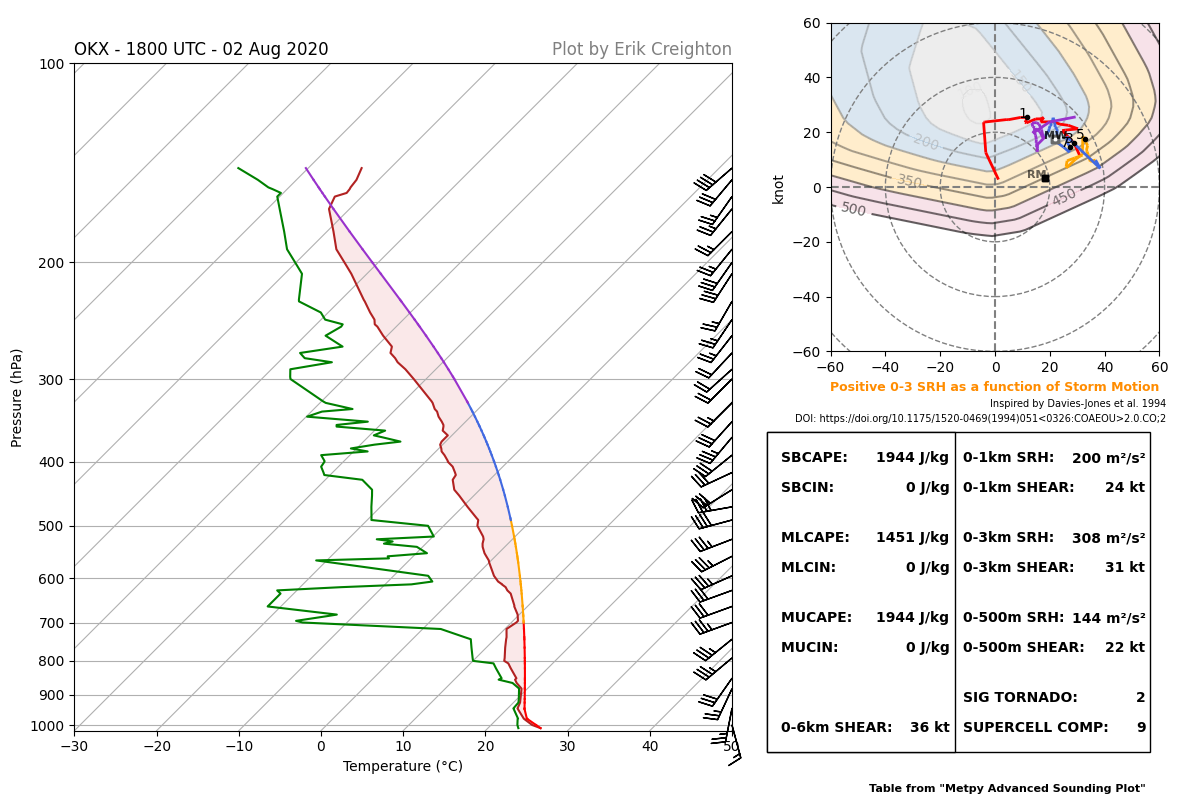

In [48]:
def plot_skewt_hodograph(df):
    # Extract variables and convert to appropriate units
    p = df['pressure'].values * units.hPa
    T = df['temperature'].values * units.degC
    Td = df['dewpoint'].values * units.degC
    u, v = mpcalc.wind_components(df['speed'].values * units.knots, df['direction'].values * units.degrees)
    height = df['height'].values * units.meter
    sq = mpcalc.specific_humidity_from_dewpoint(df['pressure'].values * units.hPa, df['dewpoint'].values * units.degC).to('g/kg')
    
    # Filter values up to 15000 meters
    mask = height.magnitude <= 14500
    p = p[mask]
    T = T[mask]
    Td = Td[mask]
    u = u[mask]
    v = v[mask]
    height = height[mask]
    sq = sq[mask]

    # Ensure there are no NaNs in the data
    valid = ~np.isnan(T) & ~np.isnan(Td) & ~np.isnan(u) & ~np.isnan(v) & ~np.isnan(height)
    p = p[valid]
    T = T[valid]
    Td = Td[valid]
    u = u[valid]
    v = v[valid]
    height = height[valid]
    sq = sq[valid]
    
    # Define custom colormap for parcel
    colors = ['r', 'orange', 'royalblue', 'darkorchid']
    cmap = ListedColormap(colors)
    boundaries = [0, 3000, 6000, 9000, 14500]
    norm = BoundaryNorm(boundaries, cmap.N)
   
    # Define custom colormap for SRH
    colors1 = ['darkgray', 'steelblue', 'orange', 'palevioletred']
    cmap1 = ListedColormap(colors1)
    boundaries1 = [0, 150, 250, 400, 1000]
    norm1 = BoundaryNorm(boundaries, cmap1.N)

    # Create the figure and set up the layout
    fig = plt.figure(figsize=(14, 10))
    gs = GridSpec(2, 2, width_ratios=[2, 1])  # Two subplots: one for Skew-T and one for Hodograph

    # Skew-T plot
    skew = SkewT(fig, rotation=45, subplot=gs[:, :-1])
    skew.plot(p, T, 'firebrick')
    skew.plot(p, Td, 'g')
    skew.ax.set_ylim(1020, 100)
    skew.ax.set_xlim(-30, 50)
    interval = np.logspace(2, 3, 40) * units.hPa
    idx = mpcalc.resample_nn_1d(p, interval)
    skew.plot_barbs(pressure=p[idx], u=u[idx], v=v[idx])

    # Parcel profile
    parcel_prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
    for i in range(len(p) - 1):
        skew.ax.plot(parcel_prof[i:i+2], p[i:i+2], color=cmap(norm(height.magnitude[i])))

    skew.shade_cape(p, T, parcel_prof, alpha=0.1, label='SBCAPE')
    skew.shade_cin(p, T, parcel_prof, Td, alpha=0.1, label='SBCIN')
    skew.ax.set_xlabel('Temperature (°C)')
    skew.ax.set_ylabel('Pressure (hPa)')
    skew.ax.set_title(f"{station} - {query_date.strftime('%H00 UTC - %d %b %Y')}", loc='left')
    skew.ax.set_title("Plot by Erik Creighton", loc='right', color='grey')

    # Hodograph plot
    hodo_ax = fig.add_subplot(gs[0, 1])
    h = Hodograph(hodo_ax, component_range=60)
    h.add_grid(increment=20)
    h.plot_colormapped(u, v, height, linewidth=2, cmap=cmap, norm=norm, zorder=5)
    RM, LM, MW = mpcalc.bunkers_storm_motion(p, u, v, height)
    
    # Add height markers at 1000m increments
    for ht in range(1000, 8001, 2000):
        index = np.argmin(np.abs(height.magnitude - ht))
        if np.isfinite(u[index]) and np.isfinite(v[index]):
            hodo_ax.plot(u[index], v[index], 'o', markersize=3, color='black', zorder=9)
            hodo_ax.text(u[index], v[index], f'{ht//1000}', fontsize=10, ha='right', zorder=9)
            h.ax.text((RM[0].m + 0.5), (RM[1].m - 0.5), 'RM', weight='bold', ha='right', fontsize=8, alpha=0.2, zorder=10)
            h.ax.plot(0, 0, RM[0].m - 0.3, RM[1].m - 0.3, 's', markersize=4, color='black', alpha=0.6, zorder=10)
            h.ax.plot((MW[0].m + 0.5), (MW[1].m - 0.5), 's', markersize=5.5, color='dimgray', alpha=0.6, zorder=9)
            h.ax.plot((MW[0].m + 0.5), (MW[1].m - 0.5), 's', markersize=2, color='white', alpha=0.6, zorder=10)
            h.ax.text((MW[0].m + 0.5), (MW[1].m - 0.5), 'MW', weight='bold', ha='center', color='black', fontsize=8, alpha=0.3, zorder=10)
            h.ax.set_xlabel('Positive 0-3 SRH as a function of Storm Motion', color='darkorange', weight='bold', fontsize=9)
    u_wind, v_wind = u, v
    # Create a grid for SRH contours
    u_grid, v_grid = np.meshgrid(np.linspace(-100, 100, 100), np.linspace(-100, 100, 100))
    
    # Compute SRH for each grid point
    srh_grid_0_3km = np.zeros_like(u_grid)
    
    for i in range(u_grid.shape[0]):
        for j in range(u_grid.shape[1]):
            u_test = u_grid[i, j] * units.knots
            v_test = v_grid[i, j] * units.knots
            srh_value = storm_relative_helicity(height, u_wind, v_wind, depth=3000 * units.meter, storm_u=u_test, storm_v=v_test)[0]
            srh_grid_0_3km[i, j] = srh_value.magnitude
    
    # Plot SRH contours with separate colormaps for positive values
    levels_positive = np.arange(50, 501, 50)
    
    contour_positive1 = plt.contourf(u_grid, v_grid, srh_grid_0_3km, levels=levels_positive, cmap=cmap1, alpha=0.2, zorder=1)
    contour_positive = plt.contour(u_grid, v_grid, srh_grid_0_3km, levels=levels_positive, cmap='gray_r', alpha=0.6, zorder=2)
    
    plt.clabel(contour_positive, inline=True, fontsize=10, fmt='%1.0f')
        # Calculate additional severe weather parameters
    kindex = mpcalc.k_index(p, T, Td)
    total_totals = mpcalc.total_totals_index(p, T, Td)

    # Mixed layer parcel properties
    ml_t, ml_td = mpcalc.mixed_layer(p, T, Td, depth=50 * units.hPa)
    ml_p, _, _ = mpcalc.mixed_parcel(p, T, Td, depth=50 * units.hPa)
    mlcape, mlcin = mpcalc.mixed_layer_cape_cin(p, T, Td, depth=50 * units.hPa)

    # Most unstable parcel properties
    mu_p, mu_t, mu_td, _ = mpcalc.most_unstable_parcel(p, T, Td, depth=50 * units.hPa)
    mucape, mucin = mpcalc.most_unstable_cape_cin(p, T, Td, depth=50 * units.hPa)

    # Estimate height of LCL in meters from hydrostatic thickness (for sig_tor)
    lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
    new_p = np.append(p[p > lcl_pressure], lcl_pressure)
    new_t = np.append(T[p > lcl_pressure], lcl_temperature)
    lcl_height = mpcalc.thickness_hydrostatic(new_p, new_t)

    # Compute Surface-based CAPE and ECAPE
    sbcape, sbcin = mpcalc.surface_based_cape_cin(p, T, Td)
    #ecape = calc_ecape(height, p, T, sq, u, v)
    LCL = mpcalc.lcl(p, T, Td)

    # Compute SRH
    (u_storm, v_storm), *_ = mpcalc.bunkers_storm_motion(p, u, v, height)
    *_, total_helicity1 = mpcalc.storm_relative_helicity(height, u, v, depth=1 * units.km,
                                                         storm_u=u_storm, storm_v=v_storm)
    *_, total_helicity3 = mpcalc.storm_relative_helicity(height, u, v, depth=3 * units.km,
                                                         storm_u=u_storm, storm_v=v_storm)
    *_, total_helicity0_5 = mpcalc.storm_relative_helicity(height, u, v, depth=0.5 * units.km,
                                                         storm_u=u_storm, storm_v=v_storm)
    *_, total_helicity6 = mpcalc.storm_relative_helicity(height, u, v, depth=6 * units.km,
                                                         storm_u=u_storm, storm_v=v_storm)

    # Compute Bulk Shear components and then magnitude
    ubshr1, vbshr1 = mpcalc.bulk_shear(p, u, v, height=height, depth=1 * units.km)
    bshear1 = mpcalc.wind_speed(ubshr1, vbshr1)
    ubshr3, vbshr3 = mpcalc.bulk_shear(p, u, v, height=height, depth=3 * units.km)
    bshear3 = mpcalc.wind_speed(ubshr3, vbshr3)
    ubshr0_5, vbshr0_5 = mpcalc.bulk_shear(p, u, v, height=height, depth=0.5 * units.km)
    bshear0_5 = mpcalc.wind_speed(ubshr0_5, vbshr0_5)
    ubshr6, vbshr6 = mpcalc.bulk_shear(p, u, v, height=height, depth=6 * units.km)
    bshear6 = mpcalc.wind_speed(ubshr6, vbshr6)

    # Use all computed pieces to calculate the Significant Tornado parameter
    sig_tor = mpcalc.significant_tornado(sbcape, lcl_height,
                                         total_helicity3, bshear3).to_base_units()

    # Perform the calculation of supercell composite if an effective layer exists
    super_comp = mpcalc.supercell_composite(mucape, total_helicity3, bshear3)

    # Add a rectangle for the table
    fig.patches.extend([plt.Rectangle((0.620, 0.14), 0.273, 0.32,
                                      edgecolor='black', facecolor='white',
                                      linewidth=1, alpha=1, transform=fig.transFigure,
                                      figure=fig)])
    fig.patches.extend([plt.Rectangle((0.620, 0.14), 0.134, 0.32,
                                      edgecolor='black', facecolor='white',
                                      linewidth=1, alpha=1, transform=fig.transFigure,
                                      figure=fig)])
    # Plot thermodynamic parameters
    plt.figtext(0.63, 0.43, 'SBCAPE: ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.75, 0.43, f'{sbcape:.0f~P}', weight='bold',
                fontsize=10, color='black', ha='right')
    plt.figtext(0.63, 0.40, 'SBCIN: ', weight='bold',
                fontsize=10, color='black', ha='left')
    plt.figtext(0.75, 0.40, f'{sbcin:.0f~P}', weight='bold',
                fontsize=10, color='black', ha='right')
    plt.figtext(0.63, 0.35, 'MLCAPE: ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.75, 0.35, f'{mlcape:.0f~P}', weight='bold',
                fontsize=10, color='black', ha='right')
    plt.figtext(0.63, 0.32, 'MLCIN: ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.75, 0.32, f'{mlcin:.0f~P}', weight='bold',
                fontsize=10, color='black', ha='right')
    plt.figtext(0.63, 0.27, 'MUCAPE: ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.75, 0.27, f'{mucape:.0f~P}', weight='bold',
                fontsize=10, color='black', ha='right')
    plt.figtext(0.63, 0.24, 'MUCIN: ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.75, 0.24, f'{mucin:.0f~P}', weight='bold',
                fontsize=10, color='black', ha='right')
    #plt.figtext(0.63, 0.19, 'ECAPE ', weight='bold', fontsize=10,
                #color='black', ha='left')
    #plt.figtext(0.75, 0.19, f'{ecape:.0f~P}', weight='bold',
                #fontsize=10, color='black', ha='right')
    plt.figtext(0.63, 0.16, '0-6km SHEAR: ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.75, 0.16, f'{bshear6:.0f~P}', weight='bold',
                fontsize=10, color='black', ha='right')

    # Plot kinematic parameters
    plt.figtext(0.76, 0.43, '0-1km SRH: ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.89, 0.43, f'{total_helicity1:.0f~P}',
                weight='bold', fontsize=10, color='black', ha='right')
    plt.figtext(0.76, 0.40, '0-1km SHEAR: ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.89, 0.40, f'{bshear1:.0f~P}', weight='bold',
                fontsize=10, color='black', ha='right')
    plt.figtext(0.76, 0.35, '0-3km SRH: ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.89, 0.35, f'{total_helicity3:.0f~P}',
                weight='bold', fontsize=10, color='black', ha='right')
    plt.figtext(0.76, 0.32, '0-3km SHEAR: ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.89, 0.32, f'{bshear3:.0f~P}', weight='bold',
                fontsize=10, color='black', ha='right')
    plt.figtext(0.76, 0.27, '0-500m SRH: ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.89, 0.27, f'{total_helicity0_5:.0f~P}',
                weight='bold', fontsize=10, color='black', ha='right')
    plt.figtext(0.76, 0.24, '0-500m SHEAR: ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.89, 0.24, f'{bshear0_5:.0f~P}', weight='bold',
                fontsize=10, color='black', ha='right')
    plt.figtext(0.76, 0.19, 'SIG TORNADO: ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.89, 0.19, f'{sig_tor[0]:.0f~P}', weight='bold', fontsize=10,
                color='black', ha='right')
    plt.figtext(0.76, 0.16, 'SUPERCELL COMP: ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.89, 0.16, f'{super_comp[0]:.0f~P}', weight='bold', fontsize=10,
                color='black', ha='right')
    plt.figtext(0.89, 0.10, 'Table from "Metpy Advanced Sounding Plot"', weight='bold', fontsize=8,
                color='black', ha='right')
    plt.figtext(0.905, 0.485, 'Inspired by Davies-Jones et al. 1994', fontsize=7,
                color='black', ha='right')
    plt.figtext(0.905, 0.47, 'DOI: https://doi.org/10.1175/1520-0469(1994)051<0326:COAEOU>2.0.CO;2', fontsize=7,
                color='black', ha='right')
 
    # Add a colorbar
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    
    plt.show()

plot_skewt_hodograph(df)


### When I edit the one below, it'll be for non-convective regimes

In [49]:
# wishlist items for the code below:
# DGZ, inferred advection?, LCL and LFC should've already been in the prior sounding, PWAT!, 

# lapse rates? 

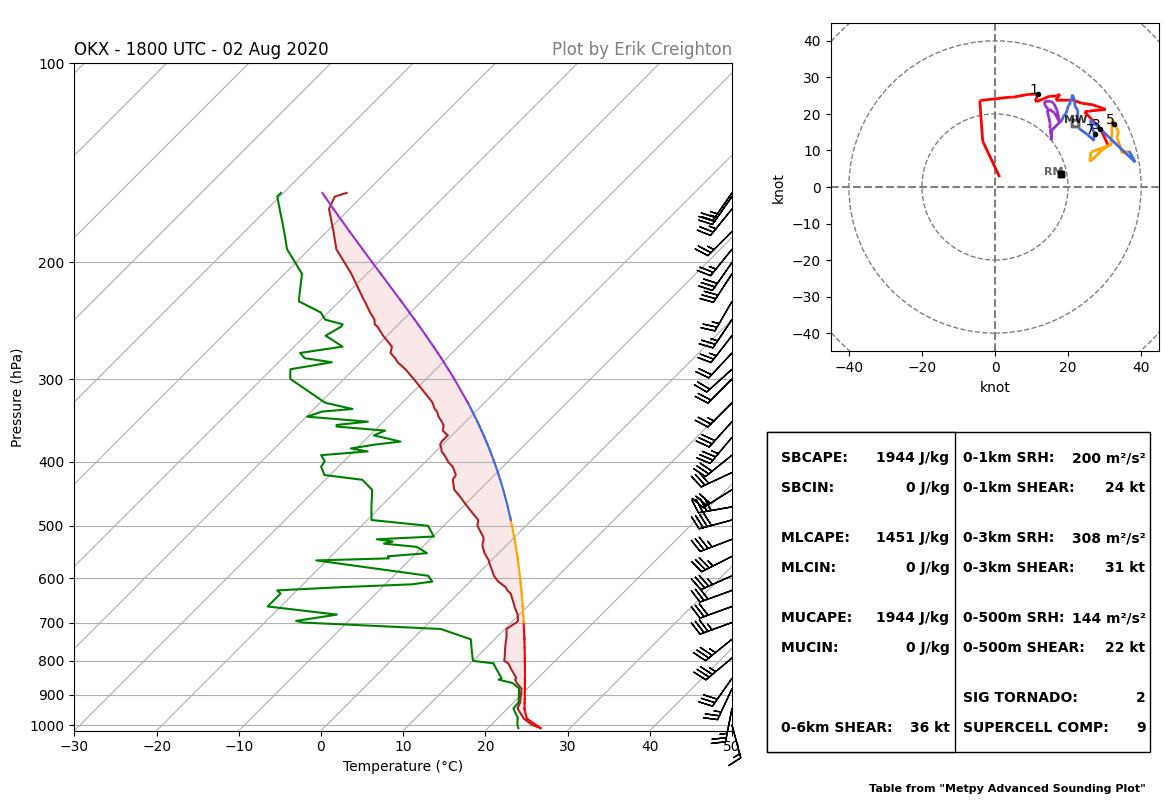

In [50]:
def plot_skewt_hodograph(df):
    # Extract variables and convert to appropriate units
    p = df['pressure'].values * units.hPa
    T = df['temperature'].values * units.degC
    Td = df['dewpoint'].values * units.degC
    u, v = mpcalc.wind_components(df['speed'].values * units.knots, df['direction'].values * units.degrees)
    height = df['height'].values * units.meter
    sq = mpcalc.specific_humidity_from_dewpoint(df['pressure'].values * units.hPa, df['dewpoint'].values * units.degC).to('g/kg')
    
    # Filter values up to 15000 meters
    mask = height.magnitude <= 14000
    p = p[mask]
    T = T[mask]
    Td = Td[mask]
    u = u[mask]
    v = v[mask]
    height = height[mask]
    sq = sq[mask]

    # Ensure there are no NaNs in the data
    valid = ~np.isnan(T) & ~np.isnan(Td) & ~np.isnan(u) & ~np.isnan(v) & ~np.isnan(height)
    p = p[valid]
    T = T[valid]
    Td = Td[valid]
    u = u[valid]
    v = v[valid]
    height = height[valid]
    sq = sq[valid]
    
    # Define custom colormap for parcel
    colors = ['r', 'orange', 'royalblue', 'darkorchid']
    cmap = ListedColormap(colors)
    boundaries = [0, 3000, 6000, 9000, 14000]
    norm = BoundaryNorm(boundaries, cmap.N)
   
    # Define custom colormap for SRH
    colors1 = ['darkgray', 'steelblue', 'orange', 'palevioletred']
    cmap1 = ListedColormap(colors1)
    boundaries1 = [0, 150, 250, 400, 1000]
    norm1 = BoundaryNorm(boundaries, cmap1.N)

    # Create the figure and set up the layout
    fig = plt.figure(figsize=(14, 10))
    gs = GridSpec(2, 2, width_ratios=[2, 1])  # Two subplots: one for Skew-T and one for Hodograph

    # Skew-T plot
    skew = SkewT(fig, rotation=45, subplot=gs[:, :-1])
    skew.plot(p, T, 'firebrick')
    skew.plot(p, Td, 'g')
    skew.ax.set_ylim(1020, 100)
    skew.ax.set_xlim(-30, 50)
    interval = np.logspace(2, 3, 40) * units.hPa
    idx = mpcalc.resample_nn_1d(p, interval)
    skew.plot_barbs(pressure=p[idx], u=u[idx], v=v[idx])

    # Parcel profile
    parcel_prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
    for i in range(len(p) - 1):
        skew.ax.plot(parcel_prof[i:i+2], p[i:i+2], color=cmap(norm(height.magnitude[i])))

    skew.shade_cape(p, T, parcel_prof, alpha=0.1, label='SBCAPE')
    skew.shade_cin(p, T, parcel_prof, Td, alpha=0.1, label='SBCIN')
    skew.ax.set_xlabel('Temperature (°C)')
    skew.ax.set_ylabel('Pressure (hPa)')
    skew.ax.set_title(f"{station} - {query_date.strftime('%H00 UTC - %d %b %Y')}", loc='left')
    skew.ax.set_title("Plot by Erik Creighton", loc='right', color='grey')

    # Hodograph plot
    hodo_ax = fig.add_subplot(gs[0, 1])
    h = Hodograph(hodo_ax, component_range=45)
    h.add_grid(increment=20)
    h.plot_colormapped(u, v, height, linewidth=2, cmap=cmap, norm=norm, zorder=5)
    RM, LM, MW = mpcalc.bunkers_storm_motion(p, u, v, height)
    
    # Add height markers at 1000m increments
    for ht in range(1000, 8001, 2000):
        index = np.argmin(np.abs(height.magnitude - ht))
        if np.isfinite(u[index]) and np.isfinite(v[index]):
            hodo_ax.plot(u[index], v[index], 'o', markersize=3, color='black', zorder=9)
            hodo_ax.text(u[index], v[index], f'{ht//1000}', fontsize=10, ha='right', zorder=9)
            h.ax.text((RM[0].m + 0.5), (RM[1].m - 0.5), 'RM', weight='bold', ha='right', fontsize=8, alpha=0.2, zorder=10)
            h.ax.plot(0, 0, RM[0].m - 0.3, RM[1].m - 0.3, 's', markersize=4, color='black', alpha=0.6, zorder=10)
            h.ax.plot((MW[0].m + 0.5), (MW[1].m - 0.5), 's', markersize=5.5, color='dimgray', alpha=0.6, zorder=9)
            h.ax.plot((MW[0].m + 0.5), (MW[1].m - 0.5), 's', markersize=2, color='white', alpha=0.6, zorder=10)
            h.ax.text((MW[0].m + 0.5), (MW[1].m - 0.5), 'MW', weight='bold', ha='center', color='black', fontsize=8, alpha=0.3, zorder=10)
    u_wind, v_wind = u, v
    # Create a grid for SRH contours
   # u_grid, v_grid = np.meshgrid(np.linspace(-100, 100, 100), np.linspace(-100, 100, 100))
    
    # Compute SRH for each grid point
   # srh_grid_0_3km = np.zeros_like(u_grid)
    
   # for i in range(u_grid.shape[0]):
   #     for j in range(u_grid.shape[1]):
   #         u_test = u_grid[i, j] * units.knots
    #        v_test = v_grid[i, j] * units.knots
    #        srh_value = storm_relative_helicity(height, u_wind, v_wind, depth=3000 * units.meter, storm_u=u_test, storm_v=v_test)[0]
   #         srh_grid_0_3km[i, j] = srh_value.magnitude
    
    # Plot SRH contours with separate colormaps for positive values
    #levels_positive = np.arange(50, 501, 50)
    
    #contour_positive1 = plt.contourf(u_grid, v_grid, srh_grid_0_3km, levels=levels_positive, cmap=cmap1, alpha=0.2, zorder=1)
    #contour_positive = plt.contour(u_grid, v_grid, srh_grid_0_3km, levels=levels_positive, cmap='gray_r', alpha=0.6, zorder=2)
    
    #plt.clabel(contour_positive, inline=True, fontsize=10, fmt='%1.0f')
        # Calculate additional severe weather parameters
    kindex = mpcalc.k_index(p, T, Td)
    total_totals = mpcalc.total_totals_index(p, T, Td)

    # Mixed layer parcel properties
    ml_t, ml_td = mpcalc.mixed_layer(p, T, Td, depth=50 * units.hPa)
    ml_p, _, _ = mpcalc.mixed_parcel(p, T, Td, depth=50 * units.hPa)
    mlcape, mlcin = mpcalc.mixed_layer_cape_cin(p, T, Td, depth=50 * units.hPa)

    # Most unstable parcel properties
    mu_p, mu_t, mu_td, _ = mpcalc.most_unstable_parcel(p, T, Td, depth=50 * units.hPa)
    mucape, mucin = mpcalc.most_unstable_cape_cin(p, T, Td, depth=50 * units.hPa)

    # Estimate height of LCL in meters from hydrostatic thickness (for sig_tor)
    lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
    new_p = np.append(p[p > lcl_pressure], lcl_pressure)
    new_t = np.append(T[p > lcl_pressure], lcl_temperature)
    lcl_height = mpcalc.thickness_hydrostatic(new_p, new_t)

    # Compute Surface-based CAPE and ECAPE
    sbcape, sbcin = mpcalc.surface_based_cape_cin(p, T, Td)
    #ecape = calc_ecape(height, p, T, sq, u, v)
    LCL = mpcalc.lcl(p, T, Td)

    # Compute SRH
    (u_storm, v_storm), *_ = mpcalc.bunkers_storm_motion(p, u, v, height)
    *_, total_helicity1 = mpcalc.storm_relative_helicity(height, u, v, depth=1 * units.km,
                                                         storm_u=u_storm, storm_v=v_storm)
    *_, total_helicity3 = mpcalc.storm_relative_helicity(height, u, v, depth=3 * units.km,
                                                         storm_u=u_storm, storm_v=v_storm)
    *_, total_helicity0_5 = mpcalc.storm_relative_helicity(height, u, v, depth=0.5 * units.km,
                                                         storm_u=u_storm, storm_v=v_storm)
    *_, total_helicity6 = mpcalc.storm_relative_helicity(height, u, v, depth=6 * units.km,
                                                         storm_u=u_storm, storm_v=v_storm)

    # Compute Bulk Shear components and then magnitude
    ubshr1, vbshr1 = mpcalc.bulk_shear(p, u, v, height=height, depth=1 * units.km)
    bshear1 = mpcalc.wind_speed(ubshr1, vbshr1)
    ubshr3, vbshr3 = mpcalc.bulk_shear(p, u, v, height=height, depth=3 * units.km)
    bshear3 = mpcalc.wind_speed(ubshr3, vbshr3)
    ubshr0_5, vbshr0_5 = mpcalc.bulk_shear(p, u, v, height=height, depth=0.5 * units.km)
    bshear0_5 = mpcalc.wind_speed(ubshr0_5, vbshr0_5)
    ubshr6, vbshr6 = mpcalc.bulk_shear(p, u, v, height=height, depth=6 * units.km)
    bshear6 = mpcalc.wind_speed(ubshr6, vbshr6)

    # Use all computed pieces to calculate the Significant Tornado parameter
    sig_tor = mpcalc.significant_tornado(sbcape, lcl_height,
                                         total_helicity3, bshear3).to_base_units()

    # Perform the calculation of supercell composite if an effective layer exists
    super_comp = mpcalc.supercell_composite(mucape, total_helicity3, bshear3)

    # Add a rectangle for the table
    fig.patches.extend([plt.Rectangle((0.620, 0.14), 0.273, 0.32,
                                      edgecolor='black', facecolor='white',
                                      linewidth=1, alpha=1, transform=fig.transFigure,
                                      figure=fig)])
    fig.patches.extend([plt.Rectangle((0.620, 0.14), 0.134, 0.32,
                                      edgecolor='black', facecolor='white',
                                      linewidth=1, alpha=1, transform=fig.transFigure,
                                      figure=fig)])
    # Plot thermodynamic parameters
    plt.figtext(0.63, 0.43, 'SBCAPE: ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.75, 0.43, f'{sbcape:.0f~P}', weight='bold',
                fontsize=10, color='black', ha='right')
    plt.figtext(0.63, 0.40, 'SBCIN: ', weight='bold',
                fontsize=10, color='black', ha='left')
    plt.figtext(0.75, 0.40, f'{sbcin:.0f~P}', weight='bold',
                fontsize=10, color='black', ha='right')
    plt.figtext(0.63, 0.35, 'MLCAPE: ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.75, 0.35, f'{mlcape:.0f~P}', weight='bold',
                fontsize=10, color='black', ha='right')
    plt.figtext(0.63, 0.32, 'MLCIN: ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.75, 0.32, f'{mlcin:.0f~P}', weight='bold',
                fontsize=10, color='black', ha='right')
    plt.figtext(0.63, 0.27, 'MUCAPE: ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.75, 0.27, f'{mucape:.0f~P}', weight='bold',
                fontsize=10, color='black', ha='right')
    plt.figtext(0.63, 0.24, 'MUCIN: ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.75, 0.24, f'{mucin:.0f~P}', weight='bold',
                fontsize=10, color='black', ha='right')
   # plt.figtext(0.63, 0.19, 'ECAPE ', weight='bold', fontsize=10,
                #color='black', ha='left')
   # plt.figtext(0.75, 0.19, f'{ecape:.0f~P}', weight='bold',
       #         fontsize=10, color='black', ha='right')
    plt.figtext(0.63, 0.16, '0-6km SHEAR: ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.75, 0.16, f'{bshear6:.0f~P}', weight='bold',
                fontsize=10, color='black', ha='right')

    # Plot kinematic parameters
    plt.figtext(0.76, 0.43, '0-1km SRH: ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.89, 0.43, f'{total_helicity1:.0f~P}',
                weight='bold', fontsize=10, color='black', ha='right')
    plt.figtext(0.76, 0.40, '0-1km SHEAR: ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.89, 0.40, f'{bshear1:.0f~P}', weight='bold',
                fontsize=10, color='black', ha='right')
    plt.figtext(0.76, 0.35, '0-3km SRH: ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.89, 0.35, f'{total_helicity3:.0f~P}',
                weight='bold', fontsize=10, color='black', ha='right')
    plt.figtext(0.76, 0.32, '0-3km SHEAR: ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.89, 0.32, f'{bshear3:.0f~P}', weight='bold',
                fontsize=10, color='black', ha='right')
    plt.figtext(0.76, 0.27, '0-500m SRH: ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.89, 0.27, f'{total_helicity0_5:.0f~P}',
                weight='bold', fontsize=10, color='black', ha='right')
    plt.figtext(0.76, 0.24, '0-500m SHEAR: ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.89, 0.24, f'{bshear0_5:.0f~P}', weight='bold',
                fontsize=10, color='black', ha='right')
    plt.figtext(0.76, 0.19, 'SIG TORNADO: ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.89, 0.19, f'{sig_tor[0]:.0f~P}', weight='bold', fontsize=10,
                color='black', ha='right')
    plt.figtext(0.76, 0.16, 'SUPERCELL COMP: ', weight='bold', fontsize=10,
                color='black', ha='left')
    plt.figtext(0.89, 0.16, f'{super_comp[0]:.0f~P}', weight='bold', fontsize=10,
                color='black', ha='right')
    plt.figtext(0.89, 0.10, 'Table from "Metpy Advanced Sounding Plot"', weight='bold', fontsize=8,
                color='black', ha='right')
 
    # Add a colorbar
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    
    plt.show()

plot_skewt_hodograph(df)
